## Bean Disease Identification
Beans are an important food cop in Uganda grown by small farmers.  Images of bean leaves were taken in the field in Uganda by Makerere AI lab in collaboration with National Crops Resources Research Institute.  A machine learning model trained to identify disease could be deployed in the field.  
   
Data Source:   
https://github.com/AI-Lab-Makerere/ibean/   

Followed along with this tutorial for the pipeline:  
https://www.tensorflow.org/datasets/keras_example

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
import seaborn as sns

## Data Download
Data is a stock tensorflow dataset.  Looking at the dataset info provided with it we see there are 2 disease classes and 1 healthy class.  The data is split into training, testing, and validation sets with 1034, 128, and 133 images respectively.  The images are rgb 500x500 pixels.  Inspection of the origin github gave the keys for converting label integers to english labels.  After unpacking the labels there are 341 to 348 instances of each class.

In [2]:
(ds_train, ds_test, ds_validation), ds_info = tfds.load(
    'beans',
    split=['train', 'test', 'validation'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/1034 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/beans/0.1.0.incompleteF3BTFP/beans-train.tfrecord*...:   0%|          | 0/…

Generating validation examples...:   0%|          | 0/133 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/beans/0.1.0.incompleteF3BTFP/beans-validation.tfrecord*...:   0%|         …

Generating test examples...:   0%|          | 0/128 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/beans/0.1.0.incompleteF3BTFP/beans-test.tfrecord*...:   0%|          | 0/1…

Dataset beans downloaded and prepared to /root/tensorflow_datasets/beans/0.1.0. Subsequent calls will reuse this data.


In [3]:
ds_info

tfds.core.DatasetInfo(
    name='beans',
    full_name='beans/0.1.0',
    description="""
    Beans is a dataset of images of beans taken in the field using smartphone
    cameras. It consists of 3 classes: 2 disease classes and the healthy class.
    Diseases depicted include Angular Leaf Spot and Bean Rust. Data was annotated by
    experts from the National Crops Resources Research Institute (NaCRRI) in Uganda
    and collected by the Makerere AI research lab.
    """,
    homepage='https://github.com/AI-Lab-Makerere/ibean/',
    data_path=PosixGPath('/tmp/tmpsolfujk_tfds'),
    file_format=tfrecord,
    download_size=171.69 MiB,
    dataset_size=171.63 MiB,
    features=FeaturesDict({
        'image': Image(shape=(500, 500, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=3),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=128, num_shards=1>,
        'train': <SplitInfo

In [4]:
label_conversion = {0:'Leaf Spot', 1:'Bean Rust', 2: 'Healthy'}

(500, 500, 3) tf.Tensor(1, shape=(), dtype=int64)


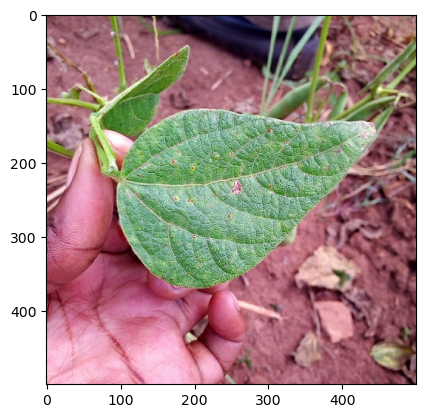

(500, 500, 3) tf.Tensor(0, shape=(), dtype=int64)


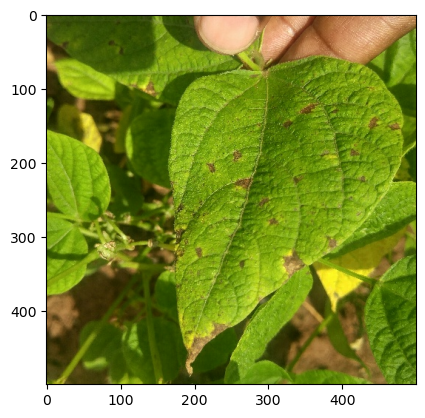

In [5]:
for image, label in ds_train.take(2):  # example is (image, label)
    print(image.shape, label)
    plt.imshow(image)
    plt.show()

In [6]:
labels = pd.Series([label for image, label in tfds.as_numpy(ds_train)])

Bean Rust    348
Leaf Spot    345
Healthy      341
dtype: int64

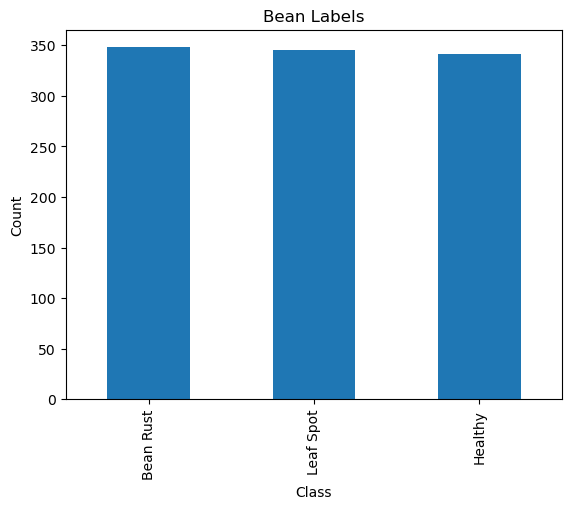

In [7]:
label_counts = labels.replace(label_conversion).value_counts()
display(label_counts)
label_counts.plot(kind='bar')
plt.title('Bean Labels')
plt.ylabel('Count')
plt.xlabel('Class')
plt.show()

In [8]:
def normalize_img(image, label):
    """Normalizes images: -> `float32`."""
    return tf.cast(image, tf.float32) / 255., tf.one_hot(label, 3)

ds_train = ds_train.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(32)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

In [9]:
ds_test = ds_test.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(32)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

## Model Construction and Training

In [10]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

Initial model architecture was [Conv2D, Conv2D, MaxPool2D] x 2, with 16 filters in each convolutional layer, 2x2 in the first max pool and 3x3 in the second max pool.  The layers were flattened and fed into a 16 node dense layer followed by a 3 node softmax layer for classification.  The first model had 33% test accuracy so additional convolutional layers were added using the same Conv2D, Conv2D, MaxPool architecture but varying the number of filters and size of pooling.  Three sets had 65% accuracy.

In [11]:
model = Sequential([
    layers.Conv2D(32,3, activation='relu', input_shape=(500,500, 3)),
    layers.BatchNormalization(),
    layers.Conv2D(32,3, activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Conv2D(32,3, activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(32,3, activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Conv2D(32,3, activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(32,3, activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(3,3)),
    layers.Conv2D(32,3, activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(32,3, activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(3,3)),
    layers.Flatten(),
    layers.Dense(16, activation = 'relu'),
    layers.Dense(3, activation = 'softmax')
])

model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics=['Accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 498, 498, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 498, 498, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 496, 496, 32)      9248      
                                                                 
 batch_normalization_1 (Batc  (None, 496, 496, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 248, 248, 32)     0         
 )                                                               
                                                        

In [12]:
history = model.fit(
    ds_train,
    epochs=6,
    validation_data=ds_test,
)

Epoch 1/6
33/33 [==============================] - 774s 23s/step - loss: 0.9878 - Accuracy: 0.5870 - val_loss: 5.8766 - val_Accuracy: 0.3359
Epoch 2/6
33/33 [==============================] - 771s 23s/step - loss: 0.8568 - Accuracy: 0.6499 - val_loss: 2.9337 - val_Accuracy: 0.3359
Epoch 3/6
33/33 [==============================] - 764s 23s/step - loss: 0.7015 - Accuracy: 0.7041 - val_loss: 2.8181 - val_Accuracy: 0.3359
Epoch 4/6
33/33 [==============================] - 762s 23s/step - loss: 0.5970 - Accuracy: 0.7611 - val_loss: 2.0780 - val_Accuracy: 0.3359
Epoch 5/6
33/33 [==============================] - 759s 23s/step - loss: 0.4845 - Accuracy: 0.7959 - val_loss: 2.3383 - val_Accuracy: 0.3750
Epoch 6/6
33/33 [==============================] - 754s 23s/step - loss: 0.4403 - Accuracy: 0.8366 - val_loss: 1.5292 - val_Accuracy: 0.4219


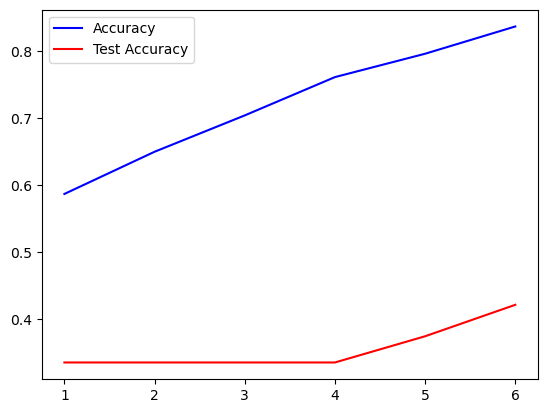

In [13]:
plt.plot(range(1,7), history.history['Accuracy'], color='b', label='Accuracy')
plt.plot(range(1,7), history.history['val_Accuracy'], color='r', label='Test Accuracy')
plt.legend()
plt.show()

## Result

## Conclusion